In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from keras.utils.vis_utils import plot_model

import sys
#sys.path.append('C:/Users/anton/Desktop/Projects/deepdl_quentin')
#from deepdl.splines import CubicSplines, TPSplines

from langdetect import detect


%load_ext nb_black

<IPython.core.display.Javascript object>

# load the data and check lyrics and popularity

In [8]:
data = pd.read_csv("C:/Users/rene-/ownCloud/spotify_data/lyric_data.csv")
data["tempo"] = data["tempo"] / data["tempo"].max()
data["text"] = data["lyrics"]

data["text"] = data.text.astype(str)
data = data[data["artists"] != "['BTS']"]
data = data.reset_index(drop=True)

data.head()

Unnamed: 0                      id                name  popularity  \
0       39511  6Pkt6qVikqPBt9bEQy8iTz  A Lover's Concerto          41   
1       39569  7HMeul83qsxs8oK1Q5vRaG    I Like It (Main)          22   
2       39577  5YEh5Ym2atMqWkDtODaQSc    Don't Ever Stray          21   
3       39657  2ltMWXxDNltgqCxFiGrRXt         I'm the One          11   
4       39663  2JPGGZwajjMk0vvhfC17RK       Away from You          12   

   duration_ms  explicit                     artists  \
0       159560         0                ['The Toys']   
1       135867         0  ['Gerry & The Pacemakers']   
2       111613         0  ['Gerry & The Pacemakers']   
3       138533         0  ['Gerry & The Pacemakers']   
4       129813         0  ['Gerry & The Pacemakers']   

                   id_artists release_date  danceability  ...  speechiness  \
0  ['6lH5PpuiMa5SpfjoIOlwCS']   2020-03-13         0.671  ...       0.0571   
1  ['3UmBeGyNwr4iDWi1vTxWi8']   2008-02-11         0.550  ...       0.0344   
2  ['3UmBeGyNwr4iDWi1vTxWi8']   2008-02-11         0.468  ...       0.0325   
3  ['3UmBeGyNwr4iDWi1vTxWi8']   2008-02-11         0.403  ...       0.0628   
4  ['3UmBeGyNwr4iDWi1vTxWi8']   2008-02-11         0.543  ...       0.0265   

   acousticness  instrumentalness  liveness  valence     tempo  \
0        0.4360          0.000000    0.1390    0.839  0.548424   
1        0.3300          0.000000    0.0907    0.964  0.671233   
2        0.3180          0.000000    0.3160    0.909  0.775171   
3        0.0565          0.000002    0.2320    0.925  0.895785   
4        0.5620          0.000004    0.1270    0.801  0.632868   

   time_signature  release_data  \
0               4    2020-03-13   
1               4    2008-02-11   
2               3    2008-02-11   
3               4    2008-02-11   
4               4    2008-02-11   

                                              lyrics  \
0  How gentle is the rain\nThat falls softly on t...   
1  I like it, I like it\nI like the way you run y...   
2  825 ALL NIGHT – PAROV STELAR\n824 BIG JET PLAN...   
3  I'm the one who cares about you\nI'm the one w...   
4  When I'm away from you\nNo wonder I feel blue\...   

                                                text  
0  How gentle is the rain\nThat falls softly on t...  
1  I like it, I like it\nI like the way you run y...  
2  825 ALL NIGHT – PAROV STELAR\n824 BIG JET PLAN...  
3  I'm the one who cares about you\nI'm the one w...  
4  When I'm away from you\nNo wonder I feel blue\...  

[5 rows x 24 columns]

<IPython.core.display.Javascript object>

In [9]:
days = []
for i in range(len(data)):
    try:
        delta = datetime.today() - datetime.fromisoformat(data["release_date"][i])
        days.append(delta.days)
    except ValueError:
        data = data.drop(i)
        

<IPython.core.display.Javascript object>

In [10]:
data["days"] = days

<IPython.core.display.Javascript object>

In [11]:
data = data.reset_index(drop=True)
print(len(data))

31325


<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Frequency'>

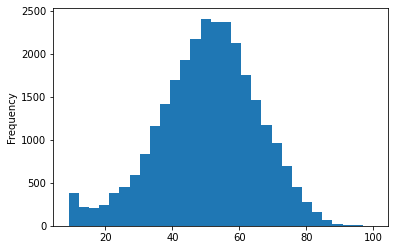

<IPython.core.display.Javascript object>

In [12]:
data.sort_values('popularity', ascending = False).head(28000)["popularity"].plot.hist(bins=30)

# get 30.0 most popular songs and check distribution

<AxesSubplot:ylabel='Frequency'>

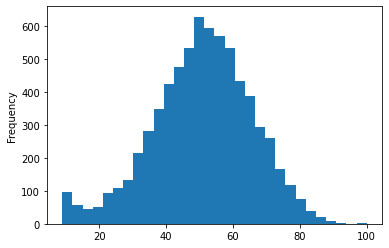

<IPython.core.display.Javascript object>

In [13]:
df = data.sort_values('popularity', ascending = False).head(28000)
df["docs"] = df["text"]

#df["popularity"] = (df["popularity"] - np.mean(df["popularity"]))/np.std(df["popularity"])

df = df.sample(n=7000, random_state=1)
df = df.reset_index(drop=True)

df["popularity"].plot.hist(bins=30)

In [14]:
most_popular = data.sort_values('popularity', ascending = False).head(10)
most_popular = most_popular.reset_index(drop=True)
most_popular[["name", "artists"]].loc[9]

name       Wellerman - Sea Shanty / 220 KID x Billen Ted ...
artists            ['Nathan Evans', '220 KID', 'Billen Ted']
Name: 9, dtype: object

<IPython.core.display.Javascript object>

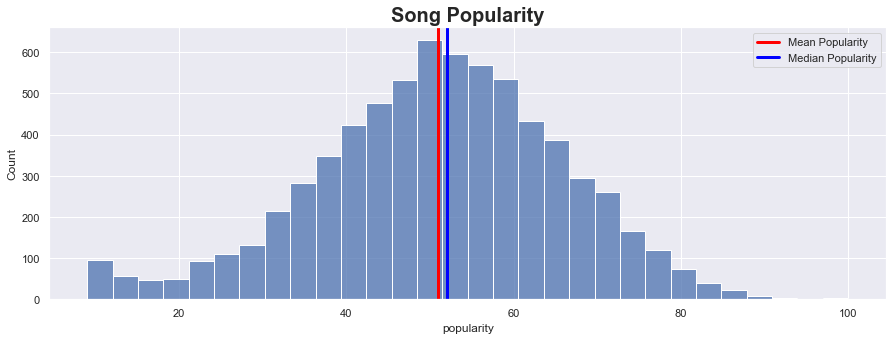

<IPython.core.display.Javascript object>

In [16]:

import seaborn as sns
sns.set(rc={"figure.figsize": (15, 5)})
fig = plt.figure()
sns.histplot(data=df, x="popularity", bins=30)
plt.axvline(df["popularity"].mean(), c="red", ls="-", lw=3, label="Mean Popularity")
plt.axvline(df["popularity"].median(), c="blue", ls="-", lw=3, label="Median Popularity")
plt.title("Song Popularity", fontsize=20, fontweight="bold")
plt.legend()
plt.show()

In [17]:
def is_en(txt):
    try:
        return detect(txt)=='en'
    except:
        return False


df = df[df['docs'].apply(is_en)]

<IPython.core.display.Javascript object>

In [18]:
df = df.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [19]:
df.to_csv("spotify_top_30.csv")

<IPython.core.display.Javascript object>

In [13]:
#tokenizer = RegexpTokenizer(r"\w+")
#
##plotting_df = data.sort_values('popularity', ascending = False).head(7000)
##plotting_df = plotting_df.reset_index(drop=True)
#
#
#artists = (df["artists"].str.strip("[]"))
#artists = artists.str.replace("'", "").str.lower()
#artists = list(artists)
#artists = [word.split(',', 1)[0] for word in artists]
#artists = " ".join(artists)
#artists = tokenizer.tokenize(artists)
#stop_ex = ["song", "rapper", "verse", "bop", "jam", "songs", "intro", "chorus", "feat", "outro"] + artists
#from backend._prepro2 import PreProcessor
#
#prepro = PreProcessor(df)
#
#df_topics = prepro.preprocessing(stops=True, stop_extension = stop_ex)

<IPython.core.display.Javascript object>

In [14]:
#df["text"] = df_topics["lemma"]

<IPython.core.display.Javascript object>

## Preprocess the lyrics:
Remove all artist names
Remove reoccuring words as Chrous and verse

In [20]:
embedding_model=SentenceTransformer("paraphrase-MiniLM-L6-v2")

embeddings =  embedding_model.encode(
            df["text"], show_progress_bar=True
        )

Downloading: 100%|██████████| 690/690 [00:00<00:00, 691kB/s]
Downloading: 100%|██████████| 3.69k/3.69k [00:00<00:00, 1.85MB/s]
Downloading: 100%|██████████| 229/229 [00:00<00:00, 229kB/s]
Downloading: 100%|██████████| 90.9M/90.9M [00:08<00:00, 10.4MB/s]
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 53.0kB/s]
Downloading: 100%|██████████| 112/112 [00:00<00:00, 112kB/s]
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 973kB/s] 
Downloading: 100%|██████████| 314/314 [00:00<00:00, 314kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 601kB/s] 
Batches: 100%|██████████| 186/186 [04:01<00:00,  1.30s/it]


<IPython.core.display.Javascript object>

In [21]:
embeddings_train, embeddings_test, df_train, df_test = train_test_split(embeddings, df, test_size=0.25, random_state=0)

<IPython.core.display.Javascript object>

In [22]:
callback = EarlyStopping(monitor="val_mse", patience=4)

#Step1. Define the model
model = Sequential()
model.add(Dense(16, activation = 'relu', input_shape = (384,)))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1))


plot_model(model, to_file='model_plot.png')
print(model.summary())

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                6160      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 6,305
Trainable params: 6,305
Non-trainable params: 0
_________________________________________________________________
None


<IPython.core.display.Javascript object>

In [27]:
model.compile(loss = tf.keras.losses.MeanSquaredError(), optimizer = optimizer)
hist = model.fit(embeddings, embeddings_train, epochs = 200)
# model(embeddings)

ValueError: Data cardinality is ambiguous:
  x sizes: 5941
  y sizes: 4455
Make sure all arrays contain the same number of samples.

<IPython.core.display.Javascript object>

In [28]:
train_dataset

NameError: name 'train_dataset' is not defined

<IPython.core.display.Javascript object>

In [23]:
a = np.empty(len(df_test))
a.fill(np.mean(df_test["popularity"]))
print(mean_squared_error(df_test["popularity"], model.predict(embeddings_test)), mean_squared_error(df_test["popularity"], a))

2867.270482685899 226.4583166530507


<IPython.core.display.Javascript object>

In [29]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["popularity"].to_numpy()
y_train = np.expand_dims(y_train, 1)
y_train = tf.cast(y_train, "float32")

spline_days = CubicSplines(df_train["days"], k=10)
x_days = spline_days.basis
x_days = tf.cast(x_days, "float32")
pen_mat_days = spline_days.penalty
pen_mat_days = tf.cast(pen_mat_days, "float32")

spline_dance = CubicSplines(df_train["danceability"], k=10)
x_dance = spline_dance.basis
x_dance = tf.cast(x_dance, "float32")
pen_mat_dance= spline_dance.penalty
pen_mat_dance = tf.cast(pen_mat_dance, "float32")

NameError: name 'CubicSplines' is not defined

<IPython.core.display.Javascript object>

In [30]:
batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((x_days, x_dance, df_train["popularity"], embeddings_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

NameError: name 'x_days' is not defined

<IPython.core.display.Javascript object>

In [22]:
init = tf.initializers.TruncatedNormal()
bias = tf.Variable(init((1, 1)))
weights_days = tf.Variable(init((9, 1)))
weights_dance = tf.Variable(init((9, 1)))
smooth = [20, 100]

<IPython.core.display.Javascript object>

In [23]:
import math
def step_decay(epoch):
    initial_lrate = 10
    drop = 0.5
    epochs_drop = 200.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate


<IPython.core.display.Javascript object>

In [25]:
optimizer = tf.optimizers.Adam(learning_rate=0.005)
loss_mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
loss_mean = tf.keras.losses.MeanSquaredError()

<IPython.core.display.Javascript object>

In [25]:
epochs = 100
loss_val = [0]
mlp_loss = [0]
counter = 0
breaker = 0

update_params =  model.trainable_weights
update_params.append(bias)
update_params.append(weights_days)
update_params.append(weights_dance)

for epoch in range(0, epochs):

    save_loss = 0

    for step, (x_batch_train_days, x_batch_train_dance, y_batch_train, embeddings) in enumerate(train_dataset):
        with tf.GradientTape() as tape:

            y_hat = tf.add(tf.matmul(x_batch_train_days, weights_days), tf.matmul(x_batch_train_days, weights_days))
            y_hat = tf.add(y_hat, tf.add(model(embeddings), bias))

            loss = loss_mse(y_batch_train, y_hat)
            loss_p = loss_mean(y_batch_train, y_hat)

            penalty_days = smooth[0] * tf.matmul(tf.transpose(weights_days), tf.matmul(pen_mat_days, weights_days))
            penalty_dance = smooth[1] * tf.matmul(tf.transpose(weights_dance), tf.matmul(pen_mat_dance, weights_dance))
            penalty = tf.add(penalty_days, penalty_dance)

            loss = tf.add(loss, penalty)

            save_loss += loss_p


        grads = tape.gradient(loss, update_params)
        optimizer.apply_gradients(zip(grads, update_params))

    

    # get validation loss of complete model
    x_new_val_days = spline_days.transform_new(df_test["days"])
    x_new_val_dance = spline_dance.transform_new(df_test["danceability"])

    y_hat_val = tf.add(tf.add(x_new_val_days @ spline_days.center_mat @ weights_days, x_new_val_dance @ spline_dance.center_mat @ weights_dance), tf.add(model.predict(embeddings_test), bias))
    validation_loss = loss_mean(df_test["popularity"], y_hat_val).numpy()
    loss_val.append(validation_loss)
    

    # get validation loss only of mlp
    mlp_mse = mean_squared_error(df_test["popularity"], model.predict(embeddings_test))
    mlp_loss.append(mlp_mse)

    # break if validation loss for 2 epochs in a row bigger than previous                                                                                                                                                                                                                                                                                                                                                   
    if mlp_loss[epoch] < mlp_loss[epoch+1]:
        breaker += 1
    else:
        breaker = 0

    if breaker >= 2:
        update_params =  []
        update_params.append(bias)
        update_params.append(weights_days)
        update_params.append(weights_dance)
        
        print("break because of mlp loss")

    
    if loss_val[epoch] < loss_val[epoch + 1]:
        #smooth[0] += step_decay(epoch)
        smooth[1] += step_decay(epoch)
        counter += 1
    else:
        counter = 0
    
    if counter >= 4:
        print("break because of validation loss")
        break


    #if count >= 2:
    #    print("break because of mlp loss")


    if epoch % 1 == 0:
        
        print(
            f"Epoch {epoch}: Training loss: {(save_loss.numpy().mean())},  mlp_loss: {mlp_mse}, Validation loss: {validation_loss}, smoother: {smooth} "
        )

Epoch 0: Training loss: 24593.05078125,  mlp_loss: 2436.2730230636644, Validation loss: 2442.018798828125, smoother: [20, 110.0] 
Epoch 1: Training loss: 19657.63671875,  mlp_loss: 1727.763452869519, Validation loss: 1745.227294921875, smoother: [20, 110.0] 
Epoch 2: Training loss: 12294.8193359375,  mlp_loss: 850.8603041739635, Validation loss: 893.4548950195312, smoother: [20, 110.0] 
Epoch 3: Training loss: 4872.3818359375,  mlp_loss: 314.13030038310086, Validation loss: 401.8791809082031, smoother: [20, 110.0] 
Epoch 4: Training loss: 2966.2001953125,  mlp_loss: 418.48476803528445, Validation loss: 530.8246459960938, smoother: [20, 120.0] 
Epoch 5: Training loss: 2808.30078125,  mlp_loss: 292.39433556675914, Validation loss: 387.4062194824219, smoother: [20, 120.0] 
Epoch 6: Training loss: 2349.3671875,  mlp_loss: 284.48249244060224, Validation loss: 370.1025695800781, smoother: [20, 120.0] 
Epoch 7: Training loss: 2271.884033203125,  mlp_loss: 268.7498316365231, Validation loss: 3

<IPython.core.display.Javascript object>

In [26]:
a = np.empty(len(df_test))
a.fill(np.mean(df_test["popularity"]))

x_new_val_days = spline_days.transform_new(df_test["days"])
x_new_val_dance = spline_dance.transform_new(df_test["danceability"])

prediction = tf.add(tf.add(x_new_val_days @ spline_days.center_mat @ weights_days, x_new_val_dance @ spline_dance.center_mat @ weights_dance), tf.add(model.predict(embeddings_test), bias))

print(mean_squared_error(df_test["popularity"], prediction), mean_squared_error(df_test["popularity"], a))

206.20337784030423 239.2929492455418


<IPython.core.display.Javascript object>

In [27]:
x_new_val_days = spline_days.transform_new(df_test["days"])
x_new_val_dance = spline_dance.transform_new(df_test["danceability"])

prediction = tf.add(tf.add(x_new_val_days @ spline_days.center_mat @ weights_days, x_new_val_dance @ spline_dance.center_mat @ weights_dance), tf.add(model.predict(embeddings_test), bias))

<IPython.core.display.Javascript object>

In [28]:
#Step2. Compile the model
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae', 'mse'])#
history = model.fit(embeddings_train, y_train, validation_data=[embeddings_test, df_test["popularity"]], epochs=50, batch_size=512,  callbacks=[callback])

Epoch 1/50
9/9 [==============================] - 0s 16ms/step - loss: 168.1346 - mae: 10.0614 - mse: 168.1346 - val_loss: 208.9236 - val_mae: 11.3933 - val_mse: 208.9236
Epoch 2/50
9/9 [==============================] - 0s 4ms/step - loss: 167.7795 - mae: 10.0502 - mse: 167.7795 - val_loss: 209.5747 - val_mae: 11.3689 - val_mse: 209.5747
Epoch 3/50
9/9 [==============================] - 0s 4ms/step - loss: 167.1912 - mae: 10.0380 - mse: 167.1912 - val_loss: 208.6167 - val_mae: 11.3855 - val_mse: 208.6167
Epoch 4/50
9/9 [==============================] - 0s 3ms/step - loss: 167.1185 - mae: 10.0478 - mse: 167.1185 - val_loss: 208.9596 - val_mae: 11.3671 - val_mse: 208.9596
Epoch 5/50
9/9 [==============================] - 0s 3ms/step - loss: 166.8299 - mae: 10.0272 - mse: 166.8299 - val_loss: 208.7759 - val_mae: 11.3641 - val_mse: 208.7759
Epoch 6/50
9/9 [==============================] - 0s 3ms/step - loss: 166.5403 - mae: 10.0158 - mse: 166.5403 - val_loss: 209.0533 - val_mae: 11.3539

<IPython.core.display.Javascript object>

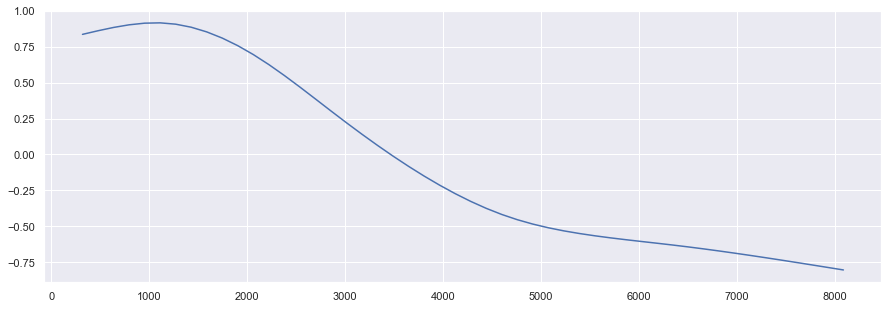

<IPython.core.display.Javascript object>

In [29]:

x_pred = np.linspace(df["days"].min(), df["days"].max())
x_new = spline_days.transform_new(x_pred)
y_hat = x_new @ spline_days.center_mat @ weights_days 
plt.plot(x_pred, y_hat)
plt.show()


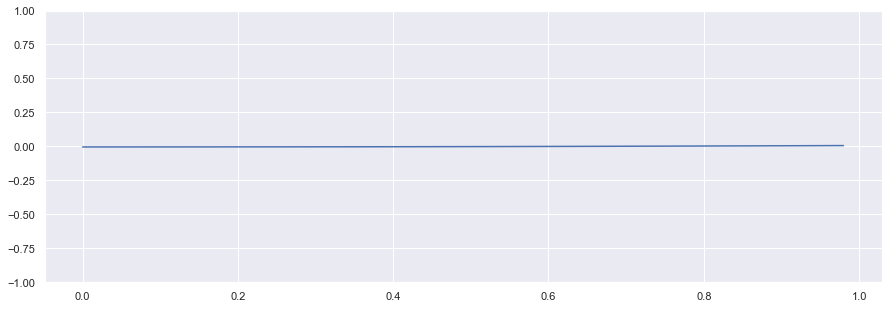

<IPython.core.display.Javascript object>

In [30]:
import matplotlib.pyplot as plt
x_pred = np.linspace(df["danceability"].min(), df["danceability"].max())
x_new = spline_dance.transform_new(x_pred)
y_hat = x_new @ spline_dance.center_mat @ weights_dance 
plt.plot(x_pred, y_hat)
plt.ylim(-1, 1)
#plt.grid(False)
plt.show()

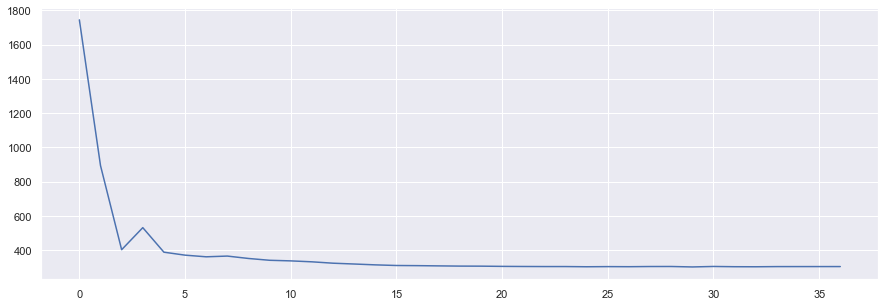

<IPython.core.display.Javascript object>

In [31]:
plt.plot(loss_val[2:])

In [32]:
import matplotlib.patches as mpatches
def ActualvPredictionsGraph(test_y, pred_y, title, prob=False):
    if max(test_y) >= max(pred_y):
        my_range = int(max(test_y))
    else:
        my_range = int(max(pred_y))
    plt.figure(figsize=(12, 3))
    plt.scatter(range(len(test_y)), test_y, color="blue")
    plt.scatter(range(len(pred_y)), pred_y, color="red")
    plt.xlabel("Index ")
    plt.ylabel("Popularity")
    plt.title(title, fontdict={"fontsize": 15})
    plt.legend(
        handles=[
            mpatches.Patch(color="red", label="prediction"),
            mpatches.Patch(color="blue", label="actual"),
        ]
    )
    plt.show()

    if prob:
        # plot actual v predicted in histogram form
        plt.figure(figsize=(12, 4))
        sns.histplot(pred_y, color="r", alpha=0.3, stat="probability", kde=True)
        sns.histplot(test_y, color="b", alpha=0.3, stat="probability", kde=True)
        plt.legend(labels=["prediction", "actual"])
        plt.title("Actual v Predict Distribution" + str(title))
        plt.show()

<IPython.core.display.Javascript object>

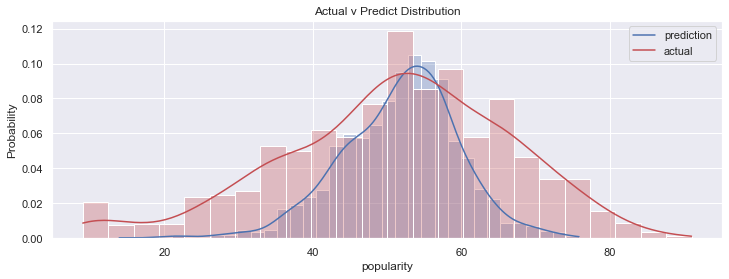

<IPython.core.display.Javascript object>

In [33]:
plt.figure(figsize=(12, 4))
sns.histplot(prediction.numpy(), color="b", alpha=0.3, stat="probability", kde=True)
sns.histplot(df_test["popularity"], color="r", alpha=0.3, stat="probability", kde=True)
plt.legend(labels=["prediction", "actual"])
plt.title("Actual v Predict Distribution")
plt.show()

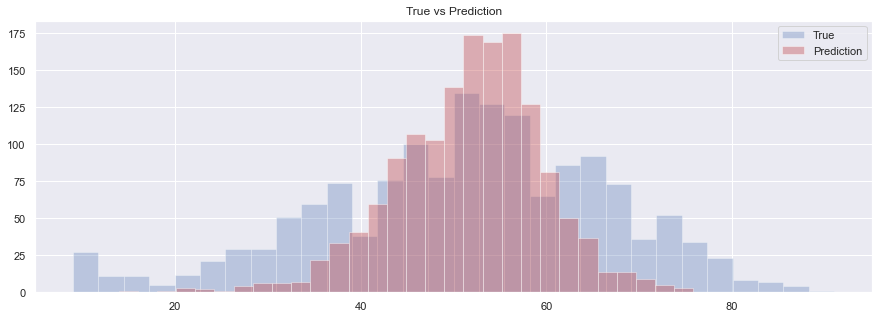

<IPython.core.display.Javascript object>

In [34]:
import seaborn as sns
sns.set(rc={"figure.figsize": (15, 5)})
plt.hist(df_test["popularity"], bins=30, alpha=0.3, color="b")
plt.hist(prediction.numpy(), bins=30, alpha=0.4, color="r")
plt.legend(labels=["True", "Prediction"])
plt.title("True vs Prediction")
plt.show()

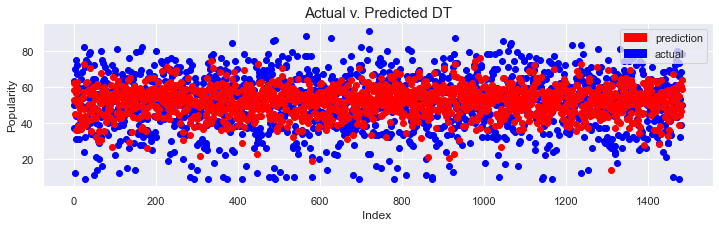

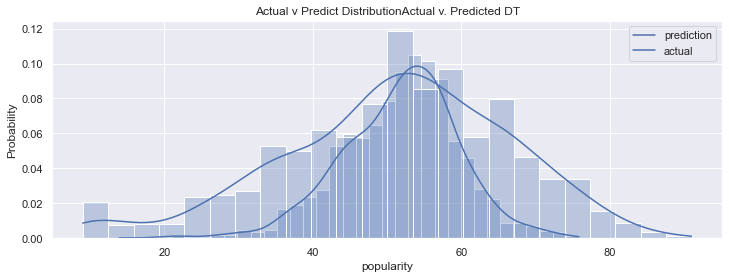

<IPython.core.display.Javascript object>

In [35]:
ActualvPredictionsGraph(df_test["popularity"], prediction.numpy(), "Actual v. Predicted DT", prob=True)

In [36]:
tokenizer = RegexpTokenizer(r"\w+")

#plotting_df = data.sort_values('popularity', ascending = False).head(7000)
#plotting_df = plotting_df.reset_index(drop=True)

plotting_df = df
plotting_df["docs"] = plotting_df["text"]
artists = (plotting_df["artists"].str.strip("[]"))
artists = artists.str.replace("'", "").str.lower()
artists = list(artists)
artists = [word.split(',', 1)[0] for word in artists]
artists = " ".join(artists)
artists = tokenizer.tokenize(artists)
stop_ex = ["song", "rapper", "verse", "bop", "jam", "songs", "intro", "chorus", "feat", "outro"] + artists
from backend._prepro2 import PreProcessor
df_topics = plotting_df#.sample(5000)
df_topics = df_topics.reset_index(drop=True)
prepro = PreProcessor(df_topics)

df_topics = prepro.preprocessing(stops=True, stop_extension = stop_ex)


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
from TTopic import TTopic
Tmodel = TTopic()

<IPython.core.display.Javascript object>

## 

In [ ]:
Tmodel.fit(df_topics["lemma"], method="kmeans", n_topics=20, optim=False)

c:\Users\anton\Desktop\Projects\NLP\NLP_venv\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
Batches:   4%|▍         | 8/186 [00:16<06:12,  2.09s/it]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
topics = Tmodel.get_topics(method="embeddings", optim=False, stop_extension=["song", "rapper", "verse", "bop", "jam"])

100%|██████████| 20/20 [19:52<00:00, 59.63s/it] 


<IPython.core.display.Javascript object>

In [ ]:
topics

{0: [('bitchin', 0.4668377637863159),
  ('wowzers', 0.44406503438949585),
  ('tha', 0.43302643299102783),
  ('suckin', 0.42443692684173584),
  ('bitch', 0.42041531205177307),
  ('sucka', 0.4191058874130249),
  ('whine', 0.41617465019226074),
  ('screamin', 0.4149841368198395),
  ('snarl', 0.4119519591331482),
  ('tho', 0.40564262866973877)],
 1: [('feelin', 0.5288076400756836),
  ('feeler', 0.5189220905303955),
  ('felt', 0.5015829801559448),
  ('feel', 0.5001001358032227),
  ('cry', 0.4192187488079071),
  ('whisper', 0.39378827810287476),
  ('emotion', 0.38026341795921326),
  ('scream', 0.380257785320282),
  ('hope', 0.3801387548446655),
  ('sadness', 0.37817317247390747)],
 2: [('whisper', 0.5128051042556763),
  ('cry', 0.4481896758079529),
  ('howl', 0.44282037019729614),
  ('lullaby', 0.44267958402633667),
  ('dream', 0.44041264057159424),
  ('scream', 0.4334353506565094),
  ('moan', 0.43288102746009827),
  ('hope', 0.4303351640701294),
  ('roar', 0.427920937538147),
  ('hear', 0.4

<IPython.core.display.Javascript object>

c:\Users\anton\Desktop\Projects\NLP\NLP_venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\anton\Desktop\Projects\NLP\NLP_venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12293 (\N{IDEOGRAPHIC ITERATION MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\anton\Desktop\Projects\NLP\NLP_venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\anton\Desktop\Projects\NLP\NLP_venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12380 (\N{HIRAGANA LETTER ZE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\anton\Desktop\Projects\NLP\NLP_venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12363 (\N{HIRA

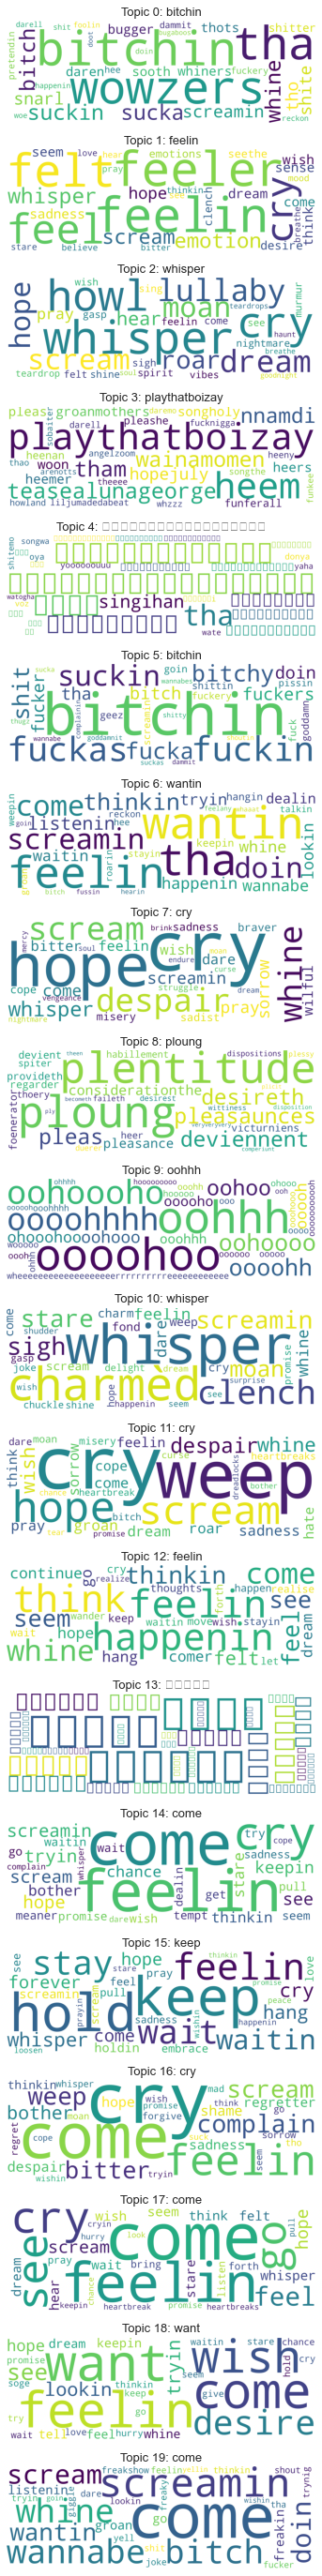

<IPython.core.display.Javascript object>

In [ ]:
Tmodel.visualize_wordclouds(n_clouds=len(topics))

<Figure size 3600x3600 with 0 Axes>

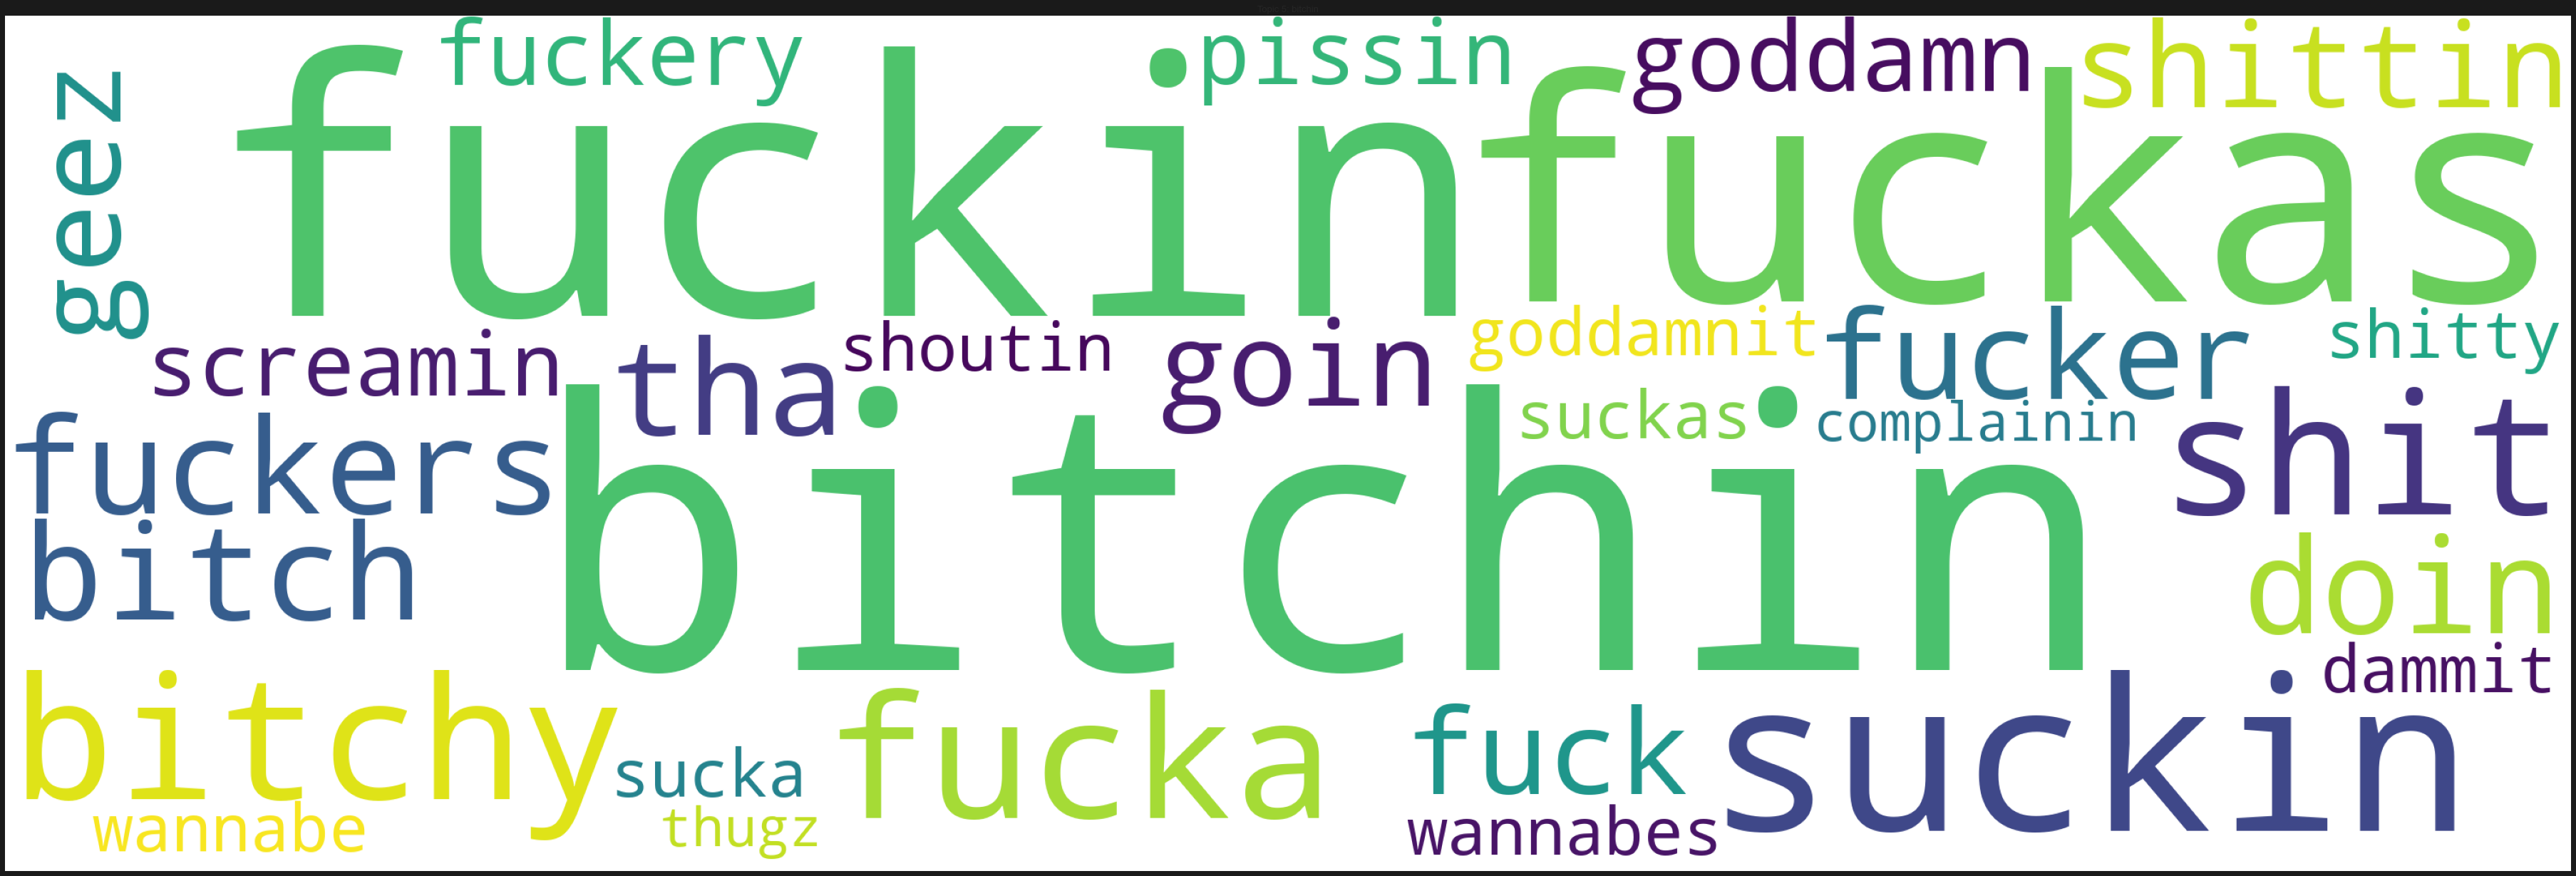

<IPython.core.display.Javascript object>

In [ ]:
Tmodel.visualize_wordclouds(n_clouds=1)